In [1]:
import string 
import re
from numpy import array,argmax,random,take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding ,Bidirectional ,RepeatVector ,TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint 
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth',200)


Using TensorFlow backend.
C:\Users\nandeesh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\nandeesh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\nandeesh\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\nandeesh\anaconda3\lib\site-packages\tensorflow\python\framewo

In [2]:
#functiont to read e=raw text file 
def read_text(filename):
    #open the file 
    file=open(filename,mode='rt',encoding='utf-8')
    #read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English -German pairs seperated by "\n" and then split these pairs into English sentence and german sentence.

In [3]:
#split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

In [4]:
data = read_text("/Users/nandeesh/Desktop/4 th sem project/deu.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentnence-pairs.However ,we will use the first 50,000 sentence pairs only to reduce the training time of the model .You can change this number as per you system computation power.

In [5]:
 deu_eng = deu_eng[:50000,:]

In [6]:
#lets take a look at our data
deu_eng

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['Who else is in there?', 'Wer ist noch dort drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['Who else was in here?', 'Wer war sonst noch hier drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['Who fixed the window?', 'Wer hat das Fenster hergerichtet?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U537')

In [7]:
# convert text to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    deu_eng[i,1] = deu_eng[i,1].lower()

deu_eng

array([['go.', 'geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['hi.', 'hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['hi.', 'grüß gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ['who else is in there?', 'wer ist noch dort drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3395974 (CK) & #3407455 (Pfirsichbaeumchen)'],
       ['who else was in here?', 'wer war sonst noch hier drin?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #3434402 (CK) & #3610264 (Jan_Schreiber)'],
       ['who fixed the window?', 'wer hat das fenster hergerichtet?',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #9855581 (DJ_Saidez) & #9855585 (brauchinet)']],
      dtype='<U537')

Text to Sequence converison:

To feed our data in a Seq2Seq model,we will have to convert both the input and output sentences into integer sequences of fixed length .Before that,lets visualise the length of the sentences .We will capture the length of all the sentences in two seprate lists  for English and German respectively.

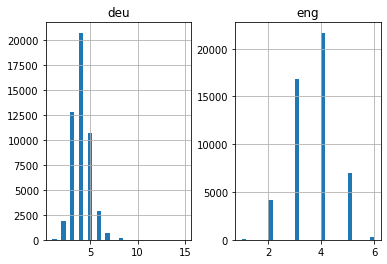

In [8]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
      eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
      deu_l.append(len(i.split()))

length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})

length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentence is 11 and that of a English phrases is 8.
Lets vectorize our text data by using Keras's Tokenizer() class.It will turn our sentences into sequences into sequences of integers.Then we will pad those sequence with zeros to make all the sequences of same length.

In [9]:
# function to build a tokenizer
def tokenization(lines):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(lines)
  return tokenizer

In [10]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6167


In [11]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10146


Given below is a function to prepare the sequence .It will also perform sequence padding to a maximum sentence length as mentioned above.

In [12]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
  # integer encode sequences
  seq = tokenizer.texts_to_sequences(lines)
  # pad sequences with 0 values
  seq = pad_sequences(seq, maxlen=length, padding='post')
  return seq

Model Building 

We will now split the data into train and test set for model training and evaluation , respectively.

In [13]:
from sklearn.model_selection import train_test_split

# split data into train and test set
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

Its time to encode the sentences.We will encode German sentences as the input sequences and English sentences as the target sequemces. It will be done for both train and test datasets.

In [14]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

Now comes the exciting part!Let us define our Seq2Seq model architecture.We are  usinfg an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.

In [15]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
  model = Sequential()
  model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
  model.add(LSTM(units))
  model.add(RepeatVector(out_timesteps))
  model.add(LSTM(units, return_sequences=True))
  model.add(Dense(out_vocab, activation='softmax'))
  return model

In [16]:
# model compilation
model = define_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Please note that we have used 'sparse_categorical_crossentropy'as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format.One hot encoding the target sequences with such a huge vocabulary might consume our system' entire memory.
It seems we are all set to start training our model .We will train it for 30 epochs and with a batch size of 512.
we will also use ModelCheckpoint() to save the best model woth lowest validation loss.

In [17]:
filename = 'model.h1.23_nandeesh'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=5, batch_size=512, validation_split = 0.2, callbacks=[checkpoint], 
                    verbose=1)


Train on 32000 samples, validate on 8000 samples
Epoch 1/5
32000/32000 [==============================] - 150s 5ms/step - loss: 3.3379 - val_loss: 2.8302

Epoch 00001: val_loss improved from inf to 2.83021, saving model to model.h1.23_nandeesh
Epoch 2/5
32000/32000 [==============================] - 157s 5ms/step - loss: 2.6917 - val_loss: 2.7576

Epoch 00002: val_loss improved from 2.83021 to 2.75755, saving model to model.h1.23_nandeesh
Epoch 3/5
32000/32000 [==============================] - 150s 5ms/step - loss: 2.5120 - val_loss: 2.5336

Epoch 00003: val_loss improved from 2.75755 to 2.53363, saving model to model.h1.23_nandeesh
Epoch 4/5
32000/32000 [==============================] - 151s 5ms/step - loss: 2.3634 - val_loss: 2.3972

Epoch 00004: val_loss improved from 2.53363 to 2.39717, saving model to model.h1.23_nandeesh
Epoch 5/5
32000/32000 [==============================] - 151s 5ms/step - loss: 2.2173 - val_loss: 2.2895

Epoch 00005: val_loss improved from 2.39717 to 2.289

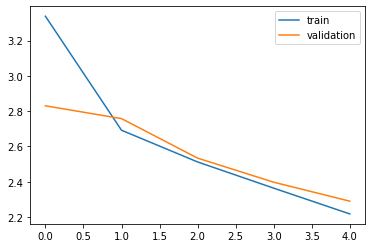

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()


In [19]:
model = load_model('model.h1.23_nandeesh')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [20]:
def get_word(n, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == n:
      return word
  return None

In [21]:
preds_text = []
for i in preds:
  temp = []
  for j in range(len(i)):
    t = get_word(i[j], eng_tokenizer)
    if j > 0:
      if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
        temp.append('')
      else:
        temp.append(t)
    else:
      if(t == None):
        temp.append('')
      else:
        temp.append(t) 

  preds_text.append(' '.join(temp))

In [22]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [23]:
# print 15 rows randomly
pred_df.sample(15)

,actual,predicted
3838,tom is sneaky.,tom is very
4602,the boy was full.,the is
9174,tom gained weight.,tom has a
2257,my friend helped me.,he is
995,tom moved to boston.,tom was a
32,sign the contract.,the
6733,try not to fall.,don't you to
5596,tom is six feet tall.,tom is a
111,we don't need him.,we you to it
7302,that didn't happen.,it's was
